Age and Gender Prediction

In [2]:
# import libraries
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import warnings
from kaggle.api.kaggle_api_extended import KaggleApi
import cv2
from tqdm.notebook import tqdm

# import tensorflow and keras
import tensorflow as tf
import keras
from keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img, array_to_img
from sklearn.model_selection import train_test_split
from keras.initializers import random_uniform, glorot_uniform, constant, identity
from keras.layers import Dropout, Input, Add, Dense, Activation, Rescaling,\
    BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, Sequential, load_model
print(dir(keras))



['DTypePolicy', 'FloatDTypePolicy', 'Function', 'Initializer', 'Input', 'InputSpec', 'KerasTensor', 'Layer', 'Loss', 'Metric', 'Model', 'Operation', 'Optimizer', 'Quantizer', 'Regularizer', 'RematScope', 'Sequential', 'StatelessScope', 'SymbolicScope', 'Variable', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_tf_keras', 'activations', 'applications', 'backend', 'callbacks', 'config', 'constraints', 'datasets', 'device', 'distillation', 'distribution', 'dtype_policies', 'export', 'initializers', 'layers', 'legacy', 'losses', 'metrics', 'mixed_precision', 'models', 'name_scope', 'ops', 'optimizers', 'preprocessing', 'quantizers', 'random', 'regularizers', 'remat', 'saving', 'src', 'tree', 'utils', 'version', 'visualization', 'wrappers']


### 1. Load Dataset

In [3]:
from dotenv import load_dotenv

# Import your custom data loading module
# (Make sure data_loader.py is in the same folder as this notebook)
from data_loader import get_unified_dataset


# Load environment variables from .env file
load_dotenv()

# --- 2. Download Datasets (Only if missing) ---
dataset_folder = './datasets'
datasets = [
    'jangedoo/utkface-new',
    'ttungl/adience-benchmark-gender-and-age-classification',
    'aiolapo/fgnet-dataset',
    'moritzm00/biometrically-filtered-famous-figure-dataset'
]

# Authenticate with Kaggle
if not os.getenv("KAGGLE_KEY"):
    print("⚠️ Error: KAGGLE_KEY not found. Please check your .env file.")
else:
    api = KaggleApi()
    api.authenticate()
    
    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    # Simple check: If folder is empty or barely populated, download everything
    # (Adjust this logic if you want to be more specific per dataset)
    if len(os.listdir(dataset_folder)) < 10:  # If less than 10 subfolders, assume datasets are missing
        print("📂 Downloading datasets from Kaggle... this may take a while.")
        for dataset in datasets:
            print(f"   --> Downloading {dataset}...")
            api.dataset_download_files(dataset, path=dataset_folder, unzip=True)
        print("✅ Download complete!")
    else:
        print("✅ Datasets already downloaded.")

# --- 3. Load & Unify Data ---
print("🔄 Processing and loading data...")
df = get_unified_dataset(dataset_folder)

# --- 4. Verify Data ---
print(f"\nTotal Images Loaded: {len(df)}")
print("Source Breakdown:")
print(df['source'].value_counts())

df.to_csv('datasets/df_first.csv', index=False)

# Show sample
df.head()

📂 Downloading datasets from Kaggle... this may take a while.
   --> Downloading jangedoo/utkface-new...
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
   --> Downloading ttungl/adience-benchmark-gender-and-age-classification...
Dataset URL: https://www.kaggle.com/datasets/ttungl/adience-benchmark-gender-and-age-classification
   --> Downloading aiolapo/fgnet-dataset...
Dataset URL: https://www.kaggle.com/datasets/aiolapo/fgnet-dataset
   --> Downloading moritzm00/biometrically-filtered-famous-figure-dataset...
Dataset URL: https://www.kaggle.com/datasets/moritzm00/biometrically-filtered-famous-figure-dataset
✅ Download complete!
🔄 Processing and loading data...
Scanning datasets...
   Searching for Adience files...
   Searching for B3FD images taken after 1980...
   Loaded 33873 B3FD images.
Loaded 74938 images total.
source
b3fd       33873
utkface    23705
adience    16358
fgnet       1002
Name: count, dtype: int64

Total Images Loaded: 74938
Source Breakdown:
sour

,image_path,age,gender,source
0,datasets\UTKFace\100_0_0_20170112213500903.jpg...,100,0,utkface
1,datasets\UTKFace\100_0_0_20170112215240346.jpg...,100,0,utkface
2,datasets\UTKFace\100_1_0_20170110183726390.jpg...,100,1,utkface
3,datasets\UTKFace\100_1_0_20170112213001988.jpg...,100,1,utkface
4,datasets\UTKFace\100_1_0_20170112213303693.jpg...,100,1,utkface


In [4]:
print("Files in ./datasets:", os.listdir('./datasets'))

Files in ./datasets: ['AdienceBenchmarkGenderAndAgeClassification', 'b3fd', 'crop_part1', 'df_first.csv', 'FGNET', 'metadata', 'UTKFace', 'utkface_aligned_cropped']


### 2. Data Exploration

In [3]:
df = pd.read_csv('datasets/df_first.csv')

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 74938 entries, 0 to 74937
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   image_path  74938 non-null  str  
 1   age         74938 non-null  int64
 2   gender      74938 non-null  int64
 3   source      74938 non-null  str  
dtypes: int64(2), str(2)
memory usage: 2.3 MB


In [5]:
# split into 2 dfs for age and gender
df_age = df[['image_path', 'age', 'source']]
df_age = df_age[df_age['age'] > 0]
df_age = df_age[df_age['age'] <= 100]

df_gender = df[['image_path', 'gender', 'source']]
df_gender = df_gender[df_gender['gender'].isin([0, 1])]

*Convert gender to Male and Female labels/categories*

remember to comment out the labelling process so it wont convert again

In [6]:
df['gender'] = df['gender'].astype('category')

df['gender'].value_counts()

gender
-1    34875
 0    20101
 1    19962
Name: count, dtype: int64

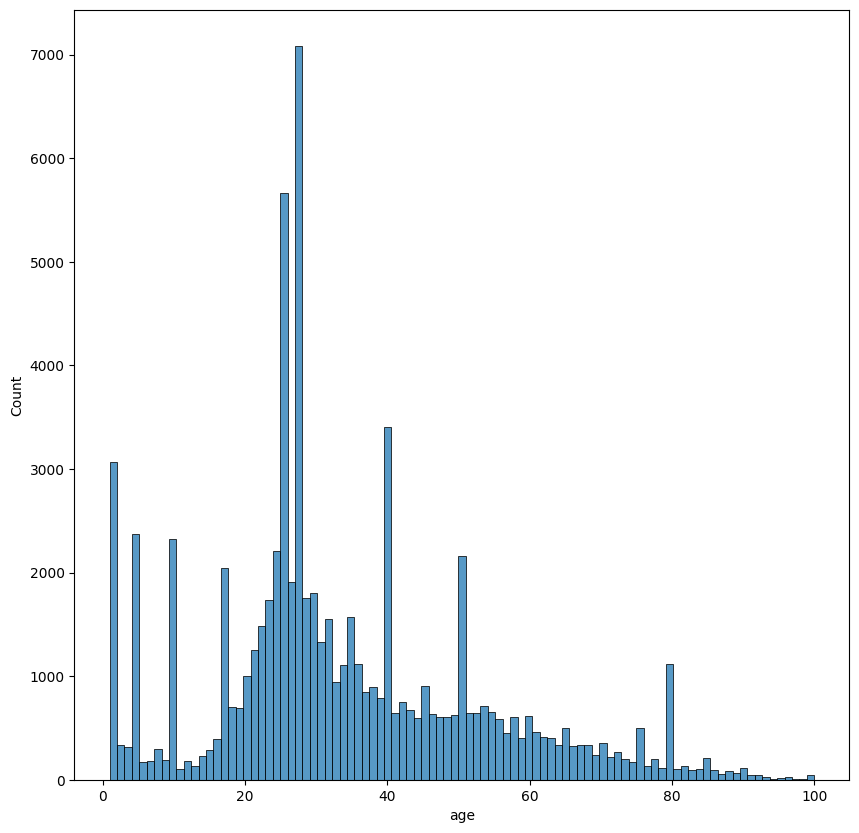

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=df_age, x="age", ax=ax)
plt.show()

Gender Distribution is quite balanced. However, the age distribution is highly imbalanced and heavily skewed towards younger individuals. The histogram reveals a significant peak of data points in the 20-30 year-old range, representing the majority of the dataset. This data imbalance is a critical factor that needs to be addressed before training the CNN model.

**Impact on the CNN Model:**

The model is highly likely to become biased towards the heavily represented age groups (e.g., 20s and 30s). This will lead to excellent prediction accuracy for these ages but poor generalization and significant performance degradation on underrepresented age groups, particularly for older individuals. The model will struggle to accurately predict the age of individuals in these categories, often defaulting to a more common age from the training set.

Hence, it is crucial to implement data balancing techniques such as oversampling the minority classes, undersampling the majority classes, or using weighted loss functions during model training.

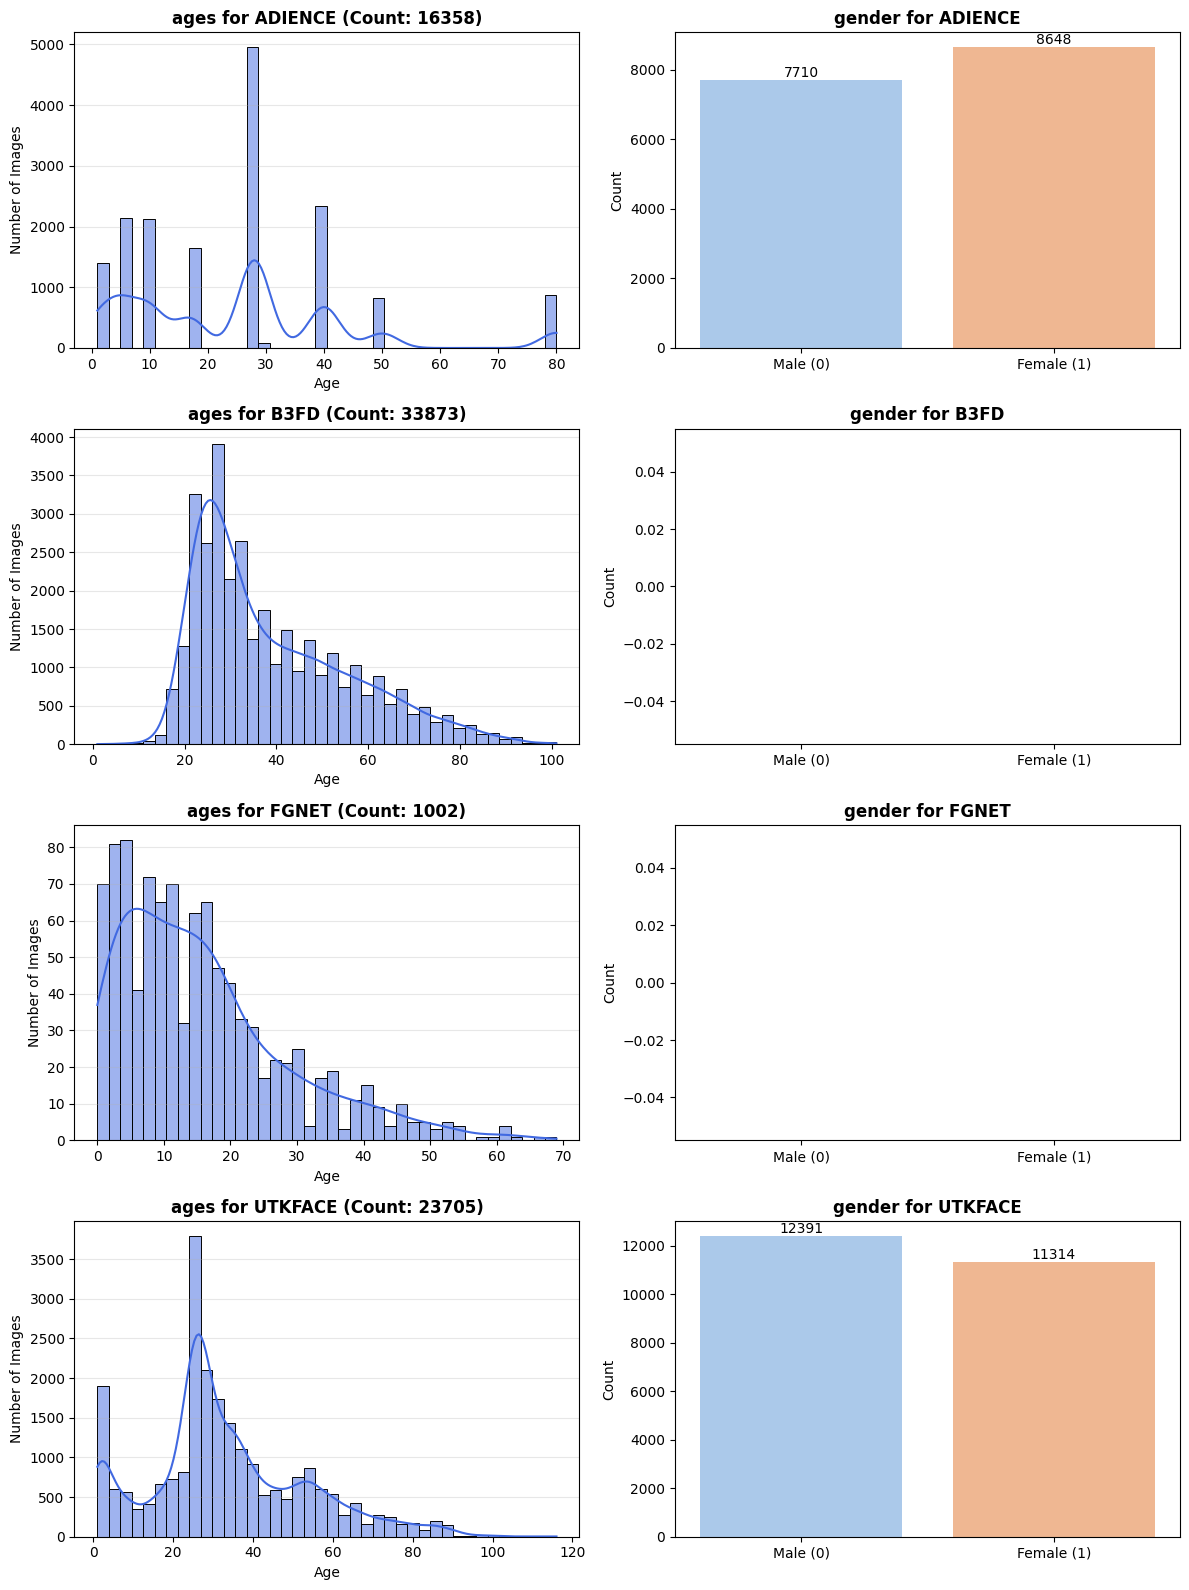

In [8]:
sources = sorted(df['source'].dropna().unique())
fig, axes = plt.subplots(len(sources), 2, figsize=(12, 4 * len(sources)))
axes = np.atleast_2d(axes)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    warnings.simplefilter("ignore", category=UserWarning)
    for i, source in enumerate(sources):
        subset = df[df['source'] == source]

        sns.histplot(subset['age'], bins=40, kde=True, ax=axes[i, 0], color='royalblue')
        axes[i, 0].set_title(f"ages for {source.upper()} (Count: {len(subset)})", fontsize=12, fontweight='bold')
        axes[i, 0].set_xlabel("Age")
        axes[i, 0].set_ylabel("Number of Images")
        axes[i, 0].grid(axis='y', alpha=0.3)

        sns.countplot(x='gender', data=subset, ax=axes[i, 1], palette='pastel', order=[0, 1])
        axes[i, 1].set_title(f"gender for {source.upper()}", fontsize=12, fontweight='bold')
        axes[i, 1].set_xticklabels(['Male (0)', 'Female (1)'])
        axes[i, 1].set_xlabel("")
        axes[i, 1].set_ylabel("Count")
        for container in axes[i, 1].containers:
            axes[i, 1].bar_label(container)

plt.tight_layout()
plt.show()

Measuring 10000 random images...


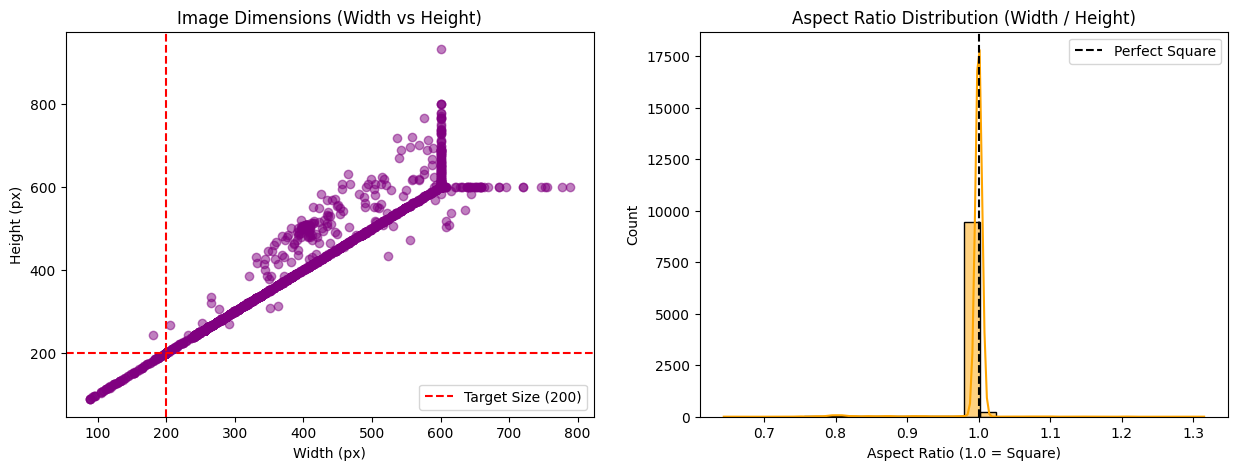

Average Size: 284x286
Smallest Width: 88
Percentage of non-square images: 10.1%


In [9]:
# 1. Sample 10000 images to check (much faster than checking all)
# If you want to check everything, remove .sample(1000)
sample_df = df.sample(n=10000, random_state=42)

widths = []
heights = []
ratios = []

print("Measuring 10000 random images...")

for img_path in sample_df['image_path']:
    try:
        with Image.open(img_path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
            ratios.append(w / h)
    except:
        continue

# --- Visualizing the Results ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Width vs Height
axes[0].scatter(widths, heights, alpha=0.5, color='purple')
axes[0].set_title("Image Dimensions (Width vs Height)")
axes[0].set_xlabel("Width (px)")
axes[0].set_ylabel("Height (px)")
axes[0].axvline(200, color='red', linestyle='--', label='Target Size (200)')
axes[0].axhline(200, color='red', linestyle='--')
axes[0].legend()

# Plot 2: Aspect Ratio Distribution
# Ratio = 1.0 is Square. >1 is Wide, <1 is Tall.
sns.histplot(ratios, bins=30, ax=axes[1], color='orange', kde=True)
axes[1].set_title("Aspect Ratio Distribution (Width / Height)")
axes[1].set_xlabel("Aspect Ratio (1.0 = Square)")
axes[1].axvline(1.0, color='black', linestyle='--', label='Perfect Square')
axes[1].legend()

plt.show()

# Summary Stats
print(f"Average Size: {int(np.mean(widths))}x{int(np.mean(heights))}")
print(f"Smallest Width: {np.min(widths)}")
print(f"Percentage of non-square images: {np.mean(np.array(ratios) != 1.0) * 100:.1f}%")

### 3. Data Preprocessing: Balancing Dataset
   - **Upsample** underrepresented age groups (rare ages with few samples).
   - **Downsample** overrepresented age groups (common ages with too many samples).
   - This helps prevent the model from overfitting to frequent ages and improves performance on rare ones.

In [10]:
age_counts = df_age['age'].value_counts().sort_values()
for i in range(100):
    if i not in age_counts.index:
        print(i)
print(age_counts)

0
age
98       3
97       7
94       9
99      13
95      21
      ... 
5     2376
1     2548
40    3401
26    3637
28    7080
Name: count, Length: 100, dtype: int64


I will need to find images for 94, 97, 98 and upsample 5 more for them. And then downsample all ages to just 2k images, in order to balance the age distribution.

In [11]:
# This step is for creating augmented images for missing ages (94, 97, 98)
# These will be created by the augmentation loop below
# For now, we'll let the augmentation script handle this

# Remove this code block - we'll get these images from the augmentation process
# new_rows = pd.DataFrame({
#     'age': [94, 97, 98],
#     'image_path': [Path('UTKFace_augmented/age_94_lady.jpg'), Path('UTKFace_augmented/age_97_lady.jpg'), Path('UTKFace_augmented/age_97_lady.jpg')],
#     'source': ['augmented', 'augmented', 'augmented']
# })

# df_age = pd.concat([df_age, new_rows], ignore_index=True, sort=False)
# df_age.tail()

In [12]:
# Image Augmentation Strategy
datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # Randomly translate images horizontally (fraction of total width)
    height_shift_range=0.1,  # Randomly translate images vertically (fraction of total height)
    brightness_range=[0.8, 1.2],  # Randomly change brightness
    shear_range=0.1,  # Shear angle in counter-clockwise direction in degrees
    zoom_range=0.1, # Randomly zoom in on images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'
)

In [13]:
# Create a folder for augmented images
augmented_path = Path("datasets/UTKFace_augmented")
augmented_path.mkdir(exist_ok=True)

In [14]:
# Look for images to augment that actually exist
# First check what data we have
age_counts = df_age['age'].value_counts().sort_values()
print("Ages with fewer than 5 images:")
missing_or_rare_ages = age_counts[age_counts < 10].index.tolist()
print(missing_or_rare_ages)

# Filter to only augment ages that actually have source images
target_ages = [age for age in missing_or_rare_ages if len(df_age[df_age['age'] == age]) > 0]
print(f"\nTarget ages for augmentation (with existing images): {target_ages}")

subset = df_age[df_age['age'].isin(target_ages)]
print(f"Found {len(subset)} images to augment")
print(subset.head())

Ages with fewer than 5 images:
[98, 97, 94]

Target ages for augmentation (with existing images): [98, 97, 94]
Found 19 images to augment
                                              image_path  age source
44516  datasets\b3fd\B3FD\benzionnetanyahu\21901391_1...   97   b3fd
47504  datasets\b3fd\B3FD\countcarljohanbernadotteofw...   94   b3fd
48228  datasets\b3fd\B3FD\danutaszaflarska\28686906_1...   98   b3fd
49107  datasets\b3fd\B3FD\dercygonalves\11933805_1907...   97   b3fd
51428  datasets\b3fd\B3FD\franceslennon\17251719_1912...   94   b3fd


In [15]:
for index, row in subset.iterrows():
    original_img_path = Path(f"{row.image_path}")
    
    # Extract just the filename without extension
    original_filename = original_img_path.stem  # e.g., "image" from "image.jpg"
    
    try:
        # Load the image
        img = Image.open(original_img_path)
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)

        i = 0
        for batch in datagen.flow(img_array, batch_size=1):
            augmented_image_array = batch[0]
            augmented_image = array_to_img(augmented_image_array)
            
            # Create filename with _augmented suffix
            augmented_filename = f"{original_filename}_{row['age']}_augmented_{i}.jpg"
            augmented_image_path = augmented_path / augmented_filename
            augmented_image.save(augmented_image_path)
            print(f"Saved augmented image: {augmented_image_path}")
            
            # Add to df_age immediately
            new_row = pd.DataFrame({
                'image_path': [augmented_image_path],
                'age': [row['age']],
                'source': ['augmented']
            })
            df_age = pd.concat([df_age, new_row], ignore_index=True)
            
            i += 1
            if i >= 2:
                break
    except Exception as e:
        print(f"Error processing {original_img_path}: {e}")
        continue

Saved augmented image: datasets\UTKFace_augmented\21901391_1910-03-25_2007_97_augmented_0.jpg
Saved augmented image: datasets\UTKFace_augmented\21901391_1910-03-25_2007_97_augmented_1.jpg
Saved augmented image: datasets\UTKFace_augmented\839957_1916-10-31_2010_94_augmented_0.jpg
Saved augmented image: datasets\UTKFace_augmented\839957_1916-10-31_2010_94_augmented_1.jpg
Saved augmented image: datasets\UTKFace_augmented\28686906_1915-02-06_2013_98_augmented_0.jpg
Saved augmented image: datasets\UTKFace_augmented\28686906_1915-02-06_2013_98_augmented_1.jpg
Saved augmented image: datasets\UTKFace_augmented\11933805_1907-06-23_2004_97_augmented_0.jpg
Saved augmented image: datasets\UTKFace_augmented\11933805_1907-06-23_2004_97_augmented_1.jpg
Saved augmented image: datasets\UTKFace_augmented\17251719_1912-09-12_2006_94_augmented_0.jpg
Saved augmented image: datasets\UTKFace_augmented\17251719_1912-09-12_2006_94_augmented_1.jpg
Saved augmented image: datasets\UTKFace_augmented\14551485_1916-

In [16]:
df_age.tail(10)

,image_path,age,source
74899,datasets\UTKFace_augmented\2659577_1915-06-08_...,94,augmented
74900,datasets\UTKFace_augmented\2659577_1915-06-08_...,94,augmented
74901,datasets\UTKFace_augmented\2058760_1915-12-02_...,97,augmented
74902,datasets\UTKFace_augmented\2058760_1915-12-02_...,97,augmented
74903,datasets\UTKFace_augmented\14045000_1908-06-24...,94,augmented
74904,datasets\UTKFace_augmented\14045000_1908-06-24...,94,augmented
74905,datasets\UTKFace_augmented\12070387_1886-05-20...,94,augmented
74906,datasets\UTKFace_augmented\12070387_1886-05-20...,94,augmented
74907,datasets\UTKFace_augmented\34229463_1912-03-19...,94,augmented
74908,datasets\UTKFace_augmented\34229463_1912-03-19...,94,augmented


#### Downsampling

In [17]:
# --- 1. Settings ---
MAX_IMAGES_PER_AGE = 2000

# --- 2. The Logic ---
processed_chunks = []
unique_ages = df_age['age'].unique()

print(f"🔄 Processing {len(unique_ages)} unique age groups...")

for age in unique_ages:
    # Get all rows for this specific age
    age_group = df_age[df_age['age'] == age]
    
    count = len(age_group)
    
    # Case A: Small group? Keep everything.
    if count <= MAX_IMAGES_PER_AGE:
        processed_chunks.append(age_group)
        
    # Case B: Too big? Downsample while keeping source ratios.
    else:
        # Calculate fraction to keep (e.g., 2000 / 4000 = 0.5)
        frac = MAX_IMAGES_PER_AGE / count
        
        # We group by 'source' within this age and sample strictly.
        # This ensures if we keep 50%, we keep 50% of UTK, 50% of Adience, etc.
        sampled = age_group.groupby('source', group_keys=False).apply(
            lambda x: x.sample(frac=frac, random_state=42)
        )
        processed_chunks.append(sampled)

# --- 3. Combine Back Together ---
# This creates a brand new clean dataframe
df_meow = pd.concat(processed_chunks, ignore_index=True)

print("✅ Downsampling complete!")
print(f"Original size: {len(df_age)}")
print(f"New size:      {len(df_meow)}")

# --- 4. Verify ---
print("\nTop 5 ages by count (Should be ~2000):")
print(df_meow['age'].value_counts().head())

🔄 Processing 100 unique age groups...
✅ Downsampling complete!
Original size: 74909
New size:      65257

Top 5 ages by count (Should be ~2000):
age
5     2001
1     2000
24    2000
25    2000
26    2000
Name: count, dtype: int64


<Axes: xlabel='age', ylabel='Count'>

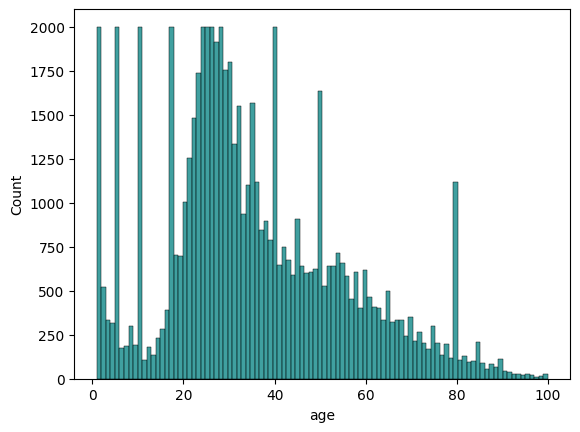

In [18]:
sns.histplot(data = df_meow['age'], bins = 100, color='teal')

##### *Data is definitely more balanced than before.*

In [19]:
# 1. Check current type
is_path_type = df_meow['image_path'].apply(lambda x: isinstance(x, Path)).all()
print(f"Current Status: Are all image_paths 'Path' objects? {is_path_type}")

# 2. FIX IT: If they are strings, convert them back to Path objects
if not is_path_type:
    print("🔄 Converting strings to Path objects...")
    df_meow['image_path'] = df_meow['image_path'].apply(Path)
    
    # Re-check
    is_path_type_now = df_meow['image_path'].apply(lambda x: isinstance(x, Path)).all()
    print(f"✅ Fixed Status: Are all image_paths 'Path' objects? {is_path_type_now}")
else:
    print("✅ No changes needed.")

Current Status: Are all image_paths 'Path' objects? False
🔄 Converting strings to Path objects...
✅ Fixed Status: Are all image_paths 'Path' objects? True


In [20]:
df_meow.info()

<class 'pandas.DataFrame'>
RangeIndex: 65257 entries, 0 to 65256
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  65257 non-null  object
 1   age         65257 non-null  int64 
 2   source      47259 non-null  str   
dtypes: int64(1), object(1), str(1)
memory usage: 1.5+ MB


### 4. Split into response and predictor

##### Data Preparation (df_meow only)
I detect and crop faces with **YOLO-Face**, resize to **224x224**, normalize to **[0,1]**, create `df_meow["age_group"]`, and prepare train/validation data for both outputs.

In [63]:
from ultralytics import YOLO
from huggingface_hub import hf_hub_download

hf_token = os.getenv("HF_TOKEN")

# --- Constants ---
IMAGE_SIZE = (224, 224)
NUM_AGE_GROUPS = 5
BATCH_SIZE = 32
VAL_SPLIT = 0.15
RANDOM_STATE = 42
AUTOTUNE = tf.data.AUTOTUNE

# --- Setup Save Directory ---
# We create a folder to save your cropped faces so you don't have to re-run YOLO later.
save_dir = Path("./processed_faces")
save_dir.mkdir(parents=True, exist_ok=True)

# --- Helper Functions ---

def map_age_to_group(age):
    age = int(age)
    if 0 <= age <= 12:
        return 0  # Child
    if 13 <= age <= 25:
        return 1  # Youth
    if 26 <= age <= 42:
        return 2  # Adult
    if 43 <= age <= 60:
        return 3  # Middle Age
    return 4      # Senior (60+)

# --- Load YOLO Model ---
yolo_face_weights = hf_hub_download(
    repo_id="Bingsu/adetailer",
    filename="face_yolov8n.pt",
    token=hf_token
)
yolo_face_model = YOLO(yolo_face_weights)

def crop_face_with_yolo(image_path: Path, target_size=IMAGE_SIZE, conf_thres: float = 0.3, margin_ratio: float = 0.15):
    # Read image in BGR format (OpenCV default)
    image_bgr = cv2.imread(str(image_path))
    if image_bgr is None:
        return None

    # Run YOLO-Face inference
    result = yolo_face_model.predict(
        source=image_bgr,
        conf=conf_thres,
        verbose=False
    )[0]

    # Handle case where no face is detected
    if result.boxes is None or len(result.boxes) == 0:
        return None

    # Select the largest face (main subject) — ignores smaller background faces
    boxes_xyxy = result.boxes.xyxy.cpu().numpy()
    areas = (boxes_xyxy[:, 2] - boxes_xyxy[:, 0]) * (boxes_xyxy[:, 3] - boxes_xyxy[:, 1])
    x1, y1, x2, y2 = boxes_xyxy[np.argmax(areas)].astype(int)

    # Expand bounding box by margin_ratio on all sides
    # YOLO boxes are tight — 15% margin gives better face context
    h, w = image_bgr.shape[:2]
    bw, bh = (x2 - x1), (y2 - y1)
    mx, my = int(bw * margin_ratio), int(bh * margin_ratio)

    x1 = max(0, x1 - mx)
    y1 = max(0, y1 - my)
    x2 = min(w, x2 + mx)
    y2 = min(h, y2 + my)

    # Crop face region
    face_bgr = image_bgr[y1:y2, x1:x2]
    if face_bgr.size == 0:
        return None

    # Convert BGR -> RGB and resize to target size
    face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB)
    face_rgb = cv2.resize(face_rgb, target_size, interpolation=cv2.INTER_AREA)

    # ✅ FIX: Return uint8 [0, 255] — do NOT normalize here.
    # cv2.imwrite() requires uint8 [0,255]. Normalizing to [0,1] floats before
    # saving causes imwrite to clamp all values to 0 (black images).
    # Normalization is handled later by the tf.data pipeline (/ 255.0).
    return face_rgb  # dtype: uint8, range: [0, 255]

print("✅ YOLO face detector loaded. crop_face_with_yolo() ready.")

✅ YOLO face detector loaded. crop_face_with_yolo() ready.


In [64]:
from tqdm import tqdm

# --- Preparation ---
df_meow = df_meow.dropna(subset=["image_path", "age"]).copy()
df_meow["age_group"] = df_meow["age"].apply(map_age_to_group).astype("int32")

processed_metadata = []
skipped_count = 0

print(f"🚀 Starting Processing on {len(df_meow)} images...")

for row in tqdm(df_meow.itertuples(index=False), total=len(df_meow)):
    image_path = Path(str(row.image_path))

    if not image_path.exists():
        skipped_count += 1
        continue

    # Crop face — returns uint8 [0, 255]
    face = crop_face_with_yolo(image_path)
    if face is None:
        skipped_count += 1
        continue

    # Convert RGB -> BGR for OpenCV before saving
    face_bgr = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)

    save_name = f"{int(row.age)}_{image_path.name}"
    save_path = save_dir / save_name
    cv2.imwrite(str(save_path), face_bgr)

    processed_metadata.append({
        "path": str(save_path),
        "age": row.age,
        "age_group": row.age_group
    })

if not processed_metadata:
    raise ValueError("❌ No images processed! Check your image paths and YOLO model.")

# Create clean DataFrame
df_processed = pd.DataFrame(processed_metadata)

# Normalization happens in tf.data pipeline — convert types only here
X = df_processed["path"].values
y_age = df_processed["age"].values.astype("float32")
y_age_group = df_processed["age_group"].values.astype("int32")

df_processed.to_csv("processed_metadata.csv", index=False)

print(f"✅ Processed {len(X)} images. Skipped {skipped_count}.")

# --- Sanity Check: Verify saved images are not black/corrupted ---
print("\n🔍 Verifying saved images...")
sample_paths = df_processed["path"].sample(min(5, len(df_processed)), random_state=42).values
all_ok = True

for p in sample_paths:
    img = cv2.imread(p)
    if img is None:
        print(f"  ❌ Could not read: {p}")
        all_ok = False
        continue
    mean_brightness = img.mean()
    if mean_brightness < 5:
        print(f"  ⚠️  Suspiciously dark image (mean={mean_brightness:.2f}): {p}")
        all_ok = False
    else:
        print(f"  ✅ OK — shape: {img.shape}, mean brightness: {mean_brightness:.1f}")

if all_ok:
    print("\n✅ All sampled images look healthy. Safe to proceed to training.")
else:
    print("\n❌ Some images look corrupted. Do NOT proceed — fix the pipeline first.")

🚀 Starting Processing on 65257 images...


100%|██████████| 65257/65257 [1:03:44<00:00, 17.06it/s]


✅ Processed 58241 images. Skipped 7016.

🔍 Verifying saved images...
  ✅ OK — shape: (224, 224, 3), mean brightness: 134.5
  ✅ OK — shape: (224, 224, 3), mean brightness: 165.9
  ✅ OK — shape: (224, 224, 3), mean brightness: 116.3
  ✅ OK — shape: (224, 224, 3), mean brightness: 73.0
  ✅ OK — shape: (224, 224, 3), mean brightness: 103.3

✅ All sampled images look healthy. Safe to proceed to training.


### Train-test split

In [65]:
# --- 1. Split Data (Train / Val / Test) ---

# I verify stratification requirements quickly to ensure fair age distribution.
stratify_vals = y_age_group if (pd.Series(y_age_group).value_counts().min() >= 2) else None

# First Split: Separate the Test Set (10% of total)
# This data is locked away and only used for the final exam.
X_temp, X_test, y_age_temp, y_age_test, y_group_temp, y_group_test = train_test_split(
    X, y_age, y_age_group,
    test_size=0.10, 
    random_state=RANDOM_STATE,
    stratify=stratify_vals
)

# Recalculate stratify values for the remaining 90%
stratify_vals_temp = y_group_temp if (pd.Series(y_group_temp).value_counts().min() >= 2) else None

# Second Split: Separate Train and Validation
# I use 0.1111 (approx 1/9) because 1/9th of the remaining 90% equals 10% of the total.
# Final Result: Train (80%), Val (10%), Test (10%)
X_train, X_val, y_age_train, y_age_val, y_group_train, y_group_val = train_test_split(
    X_temp, y_age_temp, y_group_temp,
    test_size=0.1111, 
    random_state=RANDOM_STATE,
    stratify=stratify_vals_temp
)

print(f"✅ Data Split Complete:")
print(f"Train: {len(X_train)} samples (80%)")
print(f"Val:   {len(X_val)} samples (10%)")
print(f"Test:  {len(X_test)} samples (10%)")

# --- 2. Dataset Pipeline ---

def load_and_process_image(path, targets):
    """Loads image from disk, decodes, resizes, and normalizes."""
    # I read the raw file from the disk
    img = tf.io.read_file(path)
    # I decode the compressed string into a tensor
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    # I resize it because the model expects a fixed 224x224 input
    img = tf.image.resize(img, IMAGE_SIZE)
    # I normalize pixels from 0-255 to 0-1 for faster convergence
    img = tf.cast(img, tf.float32) / 255.0
    return img, targets

def make_dataset(paths, age_targets, group_targets, training=False):
    # I create the base dataset from paths (Strings) and labels
    ds = tf.data.Dataset.from_tensor_slices((
        paths,
        { "age_group_output": group_targets, "age_output": age_targets }
    ))

    # ⚠️ CRITICAL STEP: Map paths -> Actual Images
    # num_parallel_calls=AUTOTUNE allows my CPU to load multiple images while the GPU trains
    ds = ds.map(load_and_process_image, num_parallel_calls=AUTOTUNE)

    # I only shuffle the training data. 
    # Validation and Test order should stay fixed for consistent evaluation.
    if training:
        ds = ds.shuffle(buffer_size=1000, seed=RANDOM_STATE)

    # I batch the images and prefetch the next batch to avoid bottlenecks
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# --- 3. Create Datasets ---
# I create optimized pipelines for all three sets.
# Note: training=True only for the training set!
train_ds = make_dataset(X_train, y_age_train, y_group_train, training=True)
val_ds   = make_dataset(X_val,   y_age_val,   y_group_val,   training=False)
test_ds  = make_dataset(X_test,  y_age_test,  y_group_test,  training=False)

✅ Data Split Complete:
Train: 46592 samples (80%)
Val:   5824 samples (10%)
Test:  5825 samples (10%)


#### 5. Build & Compile the Model - Architecture: EfficientNetB0 Backbone

Instead of building a custom CNN from scratch, I use **Transfer Learning** with a pre-trained EfficientNetB0 backbone.

##### **EfficientNetB0 (Pre-trained) → GlobalAveragePooling → Dense(Shared) → Split Heads**

1. **EfficientNetB0 Backbone (The "Eye"):**
   - **Why use it?** Unlike my custom CNN which learns from random weights, this model has already been trained on **14 million images** (ImageNet). It already knows how to detect edges, textures, and shapes.
   - **Benefit:** Massive improvement in feature extraction without needing millions of face images.

2. **Freezing the Backbone (Stage 1 Strategy):**
- I set backbone.trainable = False.

- Why? The new layers at the end have random weights. If I trained everything at once, these random errors would propagate back and destroy the pre-trained ImageNet patterns. I keep the backbone "frozen" first to let the new layers learn to work with it.

3. **GlobalAveragePooling2D:**
   - Replaces `Flatten`. Instead of keeping every pixel location, it averages the features map. 
   - **Benefit:** Drastically reduces the number of parameters, preventing overfitting and making the model smaller/faster.

4. **Shared Dense Layer (256 units + ReLU):**
   - Combines the high-level features extracted by EfficientNet into a vector representing the face.
   - **Dropout (Tunable):** Randomly turns off neurons to force the model to learn robust features, preventing it from relying on just one specific visual cue.

5. **Two-Head Output Strategy (Multi-Task Learning):**
   - **Head 1 (Classification):** `Softmax` output for Age Group. Acts as an "anchor" to guide the model towards the general correct range.
   - **Head 2 (Regression):** `Linear` output for Exact Age. Fine-tunes the prediction to get the specific number.
   - **Why?** Learning both tasks simultaneously improves the shared backbone features, making the model smarter than if it learned just one.

6. **Compile the model:**

> _It prepares your model for training by telling it:_
1) _How to learn (optimizer)_   = I use `adam` since it is the best choice for beginners and most practical models
2) _What to measure (metrics)_ 
3) _What to minimize (loss function)_

In [66]:
from tensorflow.keras.applications import EfficientNetB0

def build_tunable_model(hp):
    # I define the hyperparameter search space.
    # 1. Dropout: Controls how much "memory" we delete to prevent overfitting.
    dropout_rate = hp.Float("dropout_rate", min_value=0.2, max_value=0.4, step=0.05)
    
    # 2. Learning Rate: Controls how fast the model learns. 
    # Too fast = unstable; Too slow = takes forever.
    lr = hp.Choice("learning_rate", values=[1e-3, 5e-4, 1e-4])
    
    # NEW: tune the shared dense layer size
    dense_units = hp.Choice("dense_units", values=[128, 256, 512])

    # --- Input & Backbone ---
    # I define the input shape explicitly.
    inputs = Input(shape=(224, 224, 3), name="image_input")
    
    # EfficientNet expects [0, 255] pixels, but we normalized to [0, 1].
    # I rescale the inputs back to [0, 255] internally.
    x = Rescaling(255.0)(inputs)

    # I load the pre-trained EfficientNetB0.
    # pooling="avg" automatically applies GlobalAveragePooling2D.
    backbone = EfficientNetB0(
        include_top=False, 
        weights="imagenet", 
        input_shape=(224, 224, 3), 
        pooling="avg"
    )
    
    # I freeze the backbone so we don't destroy the pre-trained ImageNet weights 
    # while our new custom heads are initialized randomly.
    backbone.trainable = False
    
    # I extract the features using the frozen backbone.
    features = backbone(x, training=False)

    # --- Shared Layers ---
    # I combine features into a shared dense layer.
    shared = Dense(dense_units, activation="relu", name="shared_dense")(features)
    shared = Dropout(dropout_rate, name="shared_dropout")(shared)

    # --- Output Heads ---
    # Head 1: Age Group (Helper Task)
    age_group_output = Dense(NUM_AGE_GROUPS, activation="softmax", name="age_group_output")(shared)
    
    # Head 2: Exact Age (Main Task)
    age_output = Dense(1, activation="linear", name="age_output")(shared)

    # --- Compile ---
    model = Model(inputs=inputs, outputs=[age_group_output, age_output])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss={
            "age_group_output": "sparse_categorical_crossentropy",
            "age_output": "mean_absolute_error"
        },
        loss_weights={
            "age_group_output": 0.5, # Auxiliary weight (Guide)
            "age_output": 1.0        # Primary weight (Goal)
        },
        metrics={
            "age_group_output": "accuracy", 
            "age_output": "mae"
        }
    )
    return model

print("✅ Model Architecture defined successfully.")

✅ Model Architecture defined successfully.


#### 6. Hyperparameter Search (Tuning)

I use **Keras Tuner (Hyperband)** to automatically find the best configuration.

**What I am searching for:**
1.  **Dropout Rate:** (0.2, 0.3, 0.4, 0.5) - To find the perfect balance for regularization.
2.  **Initial Learning Rate:** (0.001, 0.0005, 0.0001) - To find the best speed to start training.

**Callbacks used during search:**
- **EarlyStopping:** Stops bad trials immediately to save time.
- **ReduceLROnPlateau:** If a trial gets stuck, it lowers the learning rate to try and squeeze out better performance. This ensures every configuration gets a fair chance to reach its best potential.

In [67]:
import keras_tuner as kt

# I initialize the Hyperband tuner.
tuner = kt.Hyperband(
    build_tunable_model,
    objective=kt.Objective("val_age_output_mae", direction="min"),
    max_epochs=20,
    factor=3,
    hyperband_iterations=2,
    directory="efficientnet_tuning",
    project_name="age_tuning_v2"
)

# --- Define Callbacks ---
# 1. Stop trials that are not improving to save time.
# removed since it can be too aggressive for tuning and may stop promising trials early.
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_age_output_mae', 
    mode="min",
    patience=4,  # I give it a bit more patience since tuning can be noisy
    restore_best_weights=True
)

# 2. Reduce Learning Rate if the model hits a plateau.
# This helps each trial converge better, making the comparison fairer.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_age_output_mae', 
    factor=0.5,    # Reduce LR to 50% of its value to not destroy it completely
    patience=3,    # if just 1 epoch, it's too aggressive for tuning
    mode = 'min',
    min_lr=1e-6
)

print("🚀 Starting Hyperparameter Search...")

# I run the search with both callbacks.
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[stop_early, reduce_lr] 
)

Trial 32 Complete [00h 42m 26s]
val_age_output_mae: 8.355512619018555

Best val_age_output_mae So Far: 7.502021312713623
Total elapsed time: 1d 23h 58m 43s

Search: Running Trial #33

Value             |Best Value So Far |Hyperparameter
0.4               |0.3               |dropout_rate
0.001             |0.001             |learning_rate
512               |512               |dense_units
3                 |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
2                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/3
 706/1456 ━━━━━━━━━━━━━━━━━━━━ 8:00 640ms/step - age_group_output_accuracy: 0.4366 - age_group_output_loss: 1.4709 - age_output_loss: 12.4218 - age_output_mae: 12.4218 - loss: 13.1572

KeyboardInterrupt: 

In [70]:
# 2. Show the top 10 trials
print("\n📊 TOP 3 TRIALS SUMMARY:")
tuner.results_summary(num_trials=3)


📊 TOP 3 TRIALS SUMMARY:
Results summary
Results in efficientnet_tuning\age_tuning_v2
Showing 3 best trials
Objective(name="val_age_output_mae", direction="min")

Trial 0024 summary
Hyperparameters:
dropout_rate: 0.30000000000000004
learning_rate: 0.001
dense_units: 512
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 7.502021312713623

Trial 0027 summary
Hyperparameters:
dropout_rate: 0.35000000000000003
learning_rate: 0.0005
dense_units: 512
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 7.591279029846191

Trial 0025 summary
Hyperparameters:
dropout_rate: 0.30000000000000004
learning_rate: 0.001
dense_units: 256
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 7.6397857666015625


In [72]:
# --- 1. Get the Best Trial ---
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Dense Units:   {best_hps.get('dense_units')}")
print(f"Dropout Rate:  {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# --- 2. Extract Validation Metrics ---
val_mae = best_trial.score  # This is the objective
val_loss = best_trial.metrics.get_last_value("val_loss")

# Safe retrieval (in case metric names differ)
def safe_get(metric_name):
    try:
        return best_trial.metrics.get_last_value(metric_name)
    except:
        return None

val_acc = safe_get("val_age_group_output_accuracy")
train_loss = safe_get("loss")
train_mae = safe_get("age_output_mae")
train_acc = safe_get("age_group_output_accuracy")

# --- 3. Print Report ---
print(f"🏆 BEST TRIAL ID: {best_trial.trial_id}")
print("-" * 40)

print(f"📉 Validation MAE (Objective): {val_mae:.4f}")
print(f"📉 Validation Loss:            {val_loss:.4f}")

if val_acc is not None:
    print(f"✅ Validation Accuracy:        {val_acc:.4f}")

print("-" * 40)

if train_loss is not None:
    print(f"📉 Training Loss:              {train_loss:.4f}")

if train_mae is not None:
    print(f"📉 Training MAE:               {train_mae:.4f}")

if train_acc is not None:
    print(f"✅ Training Accuracy:          {train_acc:.4f}")


Dense Units:   512
Dropout Rate:  0.30000000000000004
Learning Rate: 0.001
🏆 BEST TRIAL ID: 0024
----------------------------------------
📉 Validation MAE (Objective): 7.5020
📉 Validation Loss:            7.9453
✅ Validation Accuracy:        0.6156
----------------------------------------
📉 Training Loss:              7.2736
📉 Training MAE:               6.8861
✅ Training Accuracy:          0.6556


#### 7. Training the Model — Two Phases

Now that I know the best settings (dropout, learning rate, dense layer size) 
from the tuning step, it's time to actually train the model properly.

I use a technique called **Transfer Learning** — instead of building a model 
that learns everything from scratch (which would need millions of images and 
weeks of training), I start with **EfficientNetB0**, a model that was already 
trained on 14 million images by Google. It already knows how to recognise 
shapes, textures, and patterns in photos. I just need to teach it to apply 
that knowledge to predicting age from faces.

Think of it like hiring an experienced chef and teaching them your specific 
recipe — instead of training someone who has never cooked before.

The model has two parts:
- **The backbone (EfficientNet):** The experienced chef — already knows how 
  to "see" and understand images
- **The heads (my custom layers on top):** The new recipe — needs to learn 
  how to map what the backbone sees to an age prediction

Because the heads start with completely random weights, I can't train 
everything at once — the random errors from the heads would corrupt the 
backbone's carefully learned knowledge. So I train in two phases:

---

**Phase 1 — Warm-Up (10 epochs)**

I completely **freeze** the backbone (lock all its weights so they can't 
change), and only train the heads. This is like telling the chef: "Don't 
change how you cook — just learn the new recipe first."

I use a normal learning rate (`5e-4`) here because the heads are starting 
from random weights and need to take bigger steps to learn quickly. By the 
end of this phase, the MAE should drop significantly — this is the heads 
catching up to the backbone.

---

**Phase 2 — Fine-Tuning (up to 60 epochs)**

Now that the heads have learned, I **unfreeze the top 80 layers** of the 
backbone and let them gently adjust together with the heads. The bottom 
layers stay frozen because they detect universal things like edges and 
basic shapes — those don't need to change for face age prediction.

I switch to a very small learning rate (`5e-5`) here — tiny, careful steps 
so we refine without destroying the backbone's existing knowledge. This is 
like the chef now making small adjustments to their technique to perfect 
your specific recipe.

I also freeze all **BatchNorm layers** inside the backbone throughout 
fine-tuning. These layers track statistics about the data they've seen — 
if they update on my relatively small face dataset, they'll "forget" what 
they learned from 14 million ImageNet images and destabilise training.

Three safety mechanisms run throughout:
- **EarlyStopping:** Automatically stops if the model stops improving, 
  preventing wasted time and overfitting
- **ReduceLROnPlateau:** If the model gets stuck, it reduces the learning 
  rate further to help it find a better solution
- **ModelCheckpoint:** Saves the best version of the model to disk after 
  every improvement — so even if the kernel crashes, the best weights 
  are never lost
- **Weights & Biases:** Logs every epoch's metrics to a dashboard so I 
  can monitor training in real time and compare this run against 
  previous experiments

In [77]:
import wandb
from wandb.integration.keras import WandbMetricsLogger

# --- Configuration (defined first — wandb.init needs these) ---
WARMUP_EPOCHS = 7       # Phase 1: train just the heads to stabilise them
WARMUP_LR = 5e-4         # Normal LR for warm-up — heads need bigger steps to catch up
FINE_TUNE_EPOCHS = 55    # Phase 2: safety buffer, EarlyStopping will cut this short
FINE_TUNE_LR = 3e-5      # Tiny LR for fine-tuning — gentle nudges only
UNFREEZE_TOP_LAYERS = 80 # Top ~3 blocks of EfficientNetB0 (~237 layers total)

# I initialise W&B to log every epoch's metrics for this run
# This lets me compare this run against future experiments on the dashboard
wandb.init(
    project="age-prediction",
    config={
        "warmup_lr": WARMUP_LR,
        "warmup_epochs": WARMUP_EPOCHS,
        "fine_tune_lr": FINE_TUNE_LR,
        "fine_tune_epochs": FINE_TUNE_EPOCHS,
        "unfreeze_layers": UNFREEZE_TOP_LAYERS,
        "backbone": "EfficientNetB0"
    }
)

# I suppress the optimizer state mismatch warning — this is expected and harmless
# The tuner saves optimizer state from the trial, but I recompile with a new optimizer anyway
warnings.filterwarnings(
    "ignore",
    message="Skipping variable loading for optimizer",
    category=UserWarning
)

# I load the best model from the tuner — this carries the best hyperparameters
# (dropout=0.3, dense_units=512, lr=0.001) AND the weights from its 20-epoch run
# I am NOT starting from scratch — I am continuing from where the tuner left off
best_model = tuner.get_best_models(num_models=1)[0]

# I find the EfficientNet backbone layer inside the model dynamically
# I do this by name rather than hardcoding the index, in case the layer order shifts
backbone = next(layer for layer in best_model.layers if "efficientnet" in layer.name.lower())

# ══════════════════════════════════════════════════════════════════
# PHASE 1: WARM-UP — Heads only, backbone fully frozen
# The heads continue from the tuner's 20-epoch checkpoint.
# Goal: val MAE should drop further from 7.50 toward ~6-7
# ══════════════════════════════════════════════════════════════════
print("🔥 PHASE 1: Warming up the custom heads...")

# I make sure the backbone is completely frozen
# I don't want to touch EfficientNet's pre-trained ImageNet knowledge yet
backbone.trainable = False

# I recompile with a normal LR — the heads still benefit from slightly bigger steps
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=WARMUP_LR),
    loss={
        "age_group_output": "sparse_categorical_crossentropy",
        "age_output": "mean_absolute_error"
    },
    loss_weights={
        "age_group_output": 0.5,  # auxiliary task — guides the backbone
        "age_output": 1.0         # primary task — what I actually care about
    },
    metrics={"age_group_output": "accuracy", "age_output": "mae"}
)

# I use EarlyStopping with short patience here — warm-up should converge quickly
# If it hasn't improved in 3 epochs, there's no point continuing Phase 1
warmup_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_age_output_mae",
        mode="min",
        patience=2,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="age_prediction_best_warmup.keras",
        monitor="val_age_output_mae",
        mode="min",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_age_output_mae', 
        factor=0.5,    # Reduce LR to 50% of its value to not destroy it completely
        patience=2,    
        mode = 'min',
        min_lr=1e-7
    ),
    WandbMetricsLogger(log_freq="epoch")
]

history_warmup = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=WARMUP_EPOCHS,
    callbacks=warmup_callbacks,
    verbose=1
)

warmup_best_mae = min(history_warmup.history["val_age_output_mae"])
print(f"\n✅ Phase 1 complete. Best warm-up val MAE: {warmup_best_mae:.2f} years")

# I check that warm-up actually improved things before proceeding
# If MAE is still above 10 here, something is wrong and I should not continue
if warmup_best_mae > 10:
    print("⚠️  WARNING: Warm-up val MAE is still above 10. Check the data pipeline before proceeding.")
else:
    print(" Warm-up looks healthy. Proceeding to Phase 2.")

# ══════════════════════════════════════════════════════════════════
# PHASE 2: FINE-TUNING — Unfreeze top backbone layers
# Now that the heads are stable, I let the backbone adapt to face data
# Goal: MAE slowly grinds from warm-up result down toward ~5
# ══════════════════════════════════════════════════════════════════
print("\n🚀 PHASE 2: Unfreezing backbone for fine-tuning...")

# I load the best warm-up weights from disk rather than using the in-memory model
# This guarantees I'm starting from the best warm-up checkpoint, not the last epoch
best_model = tf.keras.models.load_model("age_prediction_best_warmup.keras")

# I find the backbone again — need to re-locate it since I loaded a fresh model object
backbone = next(layer for layer in best_model.layers if "efficientnet" in layer.name.lower())

# I turn the backbone's trainability back on (master switch)
backbone.trainable = True

# I re-freeze the bottom layers — they detect universal features like edges
# and gradients that don't need to change for face age prediction
for layer in backbone.layers[:-UNFREEZE_TOP_LAYERS]:
    layer.trainable = False

# I freeze ALL BatchNorm layers regardless of their position in the backbone
# BN layers track running statistics — if they update on my small face dataset,
# they'll drift away from ImageNet statistics and destabilise training
for layer in backbone.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# I verify exactly how many layers are now trainable
trainable_count = sum(1 for layer in backbone.layers if layer.trainable)
total_count = len(backbone.layers)
print(f"\n 🔓 {trainable_count}/{total_count} backbone layers trainable (BN layers frozen)")

# I MUST recompile after changing any trainable flags — otherwise the changes don't apply
# I also switch to a tiny LR here — at this stage I want gentle nudges, not big jumps
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
    loss={
        "age_group_output": "sparse_categorical_crossentropy",
        "age_output": "mean_absolute_error"
    },
    loss_weights={
        "age_group_output": 0.5,
        "age_output": 1.0
    },
    metrics={"age_group_output": "accuracy", "age_output": "mae"}
)

# I define my safety callbacks for Phase 2
callbacks_fine_tune = [
    # I stop training if val MAE doesn't improve for 5 epochs
    # patience=5 gives the model room to recover from temporary dips
    tf.keras.callbacks.EarlyStopping(
        monitor="val_age_output_mae",
        mode="min",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    # If the model gets stuck, I reduce the LR by 50% to help it find a better minimum
    # patience=2 here because at 5e-5 I want to react quickly to plateaus
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_age_output_mae",
        mode="min",
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    # I save the best model to disk after every improvement
    # This protects me against kernel crashes — I never lose my best weights
    tf.keras.callbacks.ModelCheckpoint(
        filepath="age_prediction_best_finetune.keras",
        monitor="val_age_output_mae",
        mode="min",
        save_best_only=True,
        verbose=1
    ),
    # I log every epoch to W&B so I can monitor training live
    WandbMetricsLogger(log_freq="epoch")
]

🔥 PHASE 1: Warming up the custom heads...
Epoch 1/7
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - age_group_output_accuracy: 0.6579 - age_group_output_loss: 0.7740 - age_output_loss: 6.8778 - age_output_mae: 6.8778 - loss: 7.2648
Epoch 1: val_age_output_mae improved from None to 7.54758, saving model to age_prediction_best_warmup.keras

Epoch 1: finished saving model to age_prediction_best_warmup.keras
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 791s 532ms/step - age_group_output_accuracy: 0.6612 - age_group_output_loss: 0.7696 - age_output_loss: 6.8542 - age_output_mae: 6.8542 - loss: 7.2390 - val_age_group_output_accuracy: 0.6289 - val_age_group_output_loss: 0.8663 - val_age_output_loss: 7.5476 - val_age_output_mae: 7.5476 - val_loss: 7.9807 - learning_rate: 5.0000e-04
Epoch 2/7
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - age_group_output_accuracy: 0.6577 - age_group_output_loss: 0.7711 - age_output_loss: 6.8230 - age_output_mae: 6.8230 - loss: 7.2085
Epoch 2: val_age_output_mae improved from

🟢 Age Prediction Metrics (regression)
| Metric             | Meaning                                                   |
| ------------------ | --------------------------------------------------------- |
| `age_output_loss`  | Mean Squared Error (how off the predictions are, squared) |
| `age_output_mae`   | Mean Absolute Error (average error in years)              |
| `val_age_output_` | Same as above, but on validation set (unseen data)        |

🟢 Gender Prediction Metrics (classification)
| Metric                       | Meaning                                                      |
| ---------------------------- | ------------------------------------------------------------ |
| `gender_output_accuracy`     | % of genders predicted correctly on training data            |
| `val_gender_output_accuracy` | Same for validation (unseen) data                            |
| `gender_output_loss`         | How wrong the model was on predicting gender (cross-entropy) |


✅ What we can conclude:

1) Model is learning age and gender well
- MAE dropped from 7.8901 → 5.7301 on training
- Validation MAE dropped from 11.1618 → 8.4502

- Gender training accuracy went from 86.46% → 94.58%
- Validation accuracy stayed strong: ~ 86%–88%

2) **No severe overfitting** - Training and validation accuracy/MAE **stay close**


In [78]:
print(f"\n🚀 Starting Phase 2 Fine-Tuning...")
print(f"   LR: {FINE_TUNE_LR} | Max Epochs: {FINE_TUNE_EPOCHS} | Unfrozen Layers: {UNFREEZE_TOP_LAYERS}")

history_fine = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=callbacks_fine_tune,
    verbose=1
)

print(f"\n✅ Training Complete.")
print(f"   Phase 1 best val MAE: {warmup_best_mae:.2f} years")
print(f"   Phase 2 best val MAE: {min(history_fine.history['val_age_output_mae']):.2f} years")

# I save the final model and log it to W&B as a versioned artifact
best_model.save("age_prediction_model_final.keras")
print(" Final model saved as age_prediction_model_final.keras")

artifact = wandb.Artifact(name="age-prediction-final", type="model")
artifact.add_file("age_prediction_model_final.keras")
wandb.log_artifact(artifact)

wandb.finish()
print(" W&B run closed. View results at https://wandb.ai")


🚀 Starting Phase 2 Fine-Tuning...
   LR: 3e-05 | Max Epochs: 55 | Unfrozen Layers: 80
Epoch 1/55
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - age_group_output_accuracy: 0.6686 - age_group_output_loss: 0.7575 - age_output_loss: 6.8055 - age_output_mae: 6.8055 - loss: 7.1842
Epoch 1: val_age_output_mae improved from None to 7.02585, saving model to age_prediction_best_finetune.keras

Epoch 1: finished saving model to age_prediction_best_finetune.keras
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 1125s 763ms/step - age_group_output_accuracy: 0.6791 - age_group_output_loss: 0.7361 - age_output_loss: 6.6556 - age_output_mae: 6.6556 - loss: 7.0236 - val_age_group_output_accuracy: 0.6525 - val_age_group_output_loss: 0.8139 - val_age_output_loss: 7.0259 - val_age_output_mae: 7.0259 - val_loss: 7.4328 - learning_rate: 3.0000e-05
Epoch 2/55
1456/1456 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - age_group_output_accuracy: 0.6930 - age_group_output_loss: 0.7028 - age_output_loss: 6.2442 - age_output_mae: 6.2442 - lo

epoch/age_group_output_accuracy,▁▁▁▁▂▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇█████████████████
epoch/age_group_output_loss,████▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/age_output_loss,█████▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/age_output_mae,█████▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▁▂▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
epoch/learning_rate,███▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█████▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_age_group_output_accuracy,▂▂▁▂▄▅▅▆▆▆▇▇▆▇▇▆▇▇█▇▇▇▇█████████████████
epoch/val_age_group_output_loss,▇▇██▅▄▄▃▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_age_output_loss,▇▇██▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+2,...


 W&B run closed. View results at https://wandb.ai


### 8. Save the Final Model

In [80]:
# Re-open the W&B run to log the final artifact
# Use resume="allow" so it continues the existing run rather than creating a new one
wandb.init(
    project="age-prediction",
    resume="allow"
)

best_model.save("age_prediction_model_final.keras")
print("✅ Final model saved as age_prediction_model_final.keras")

artifact = wandb.Artifact(name="age-prediction-final", type="model")
artifact.add_file("age_prediction_model_final.keras")
wandb.log_artifact(artifact)

wandb.finish()
print(" W&B run closed. View results at https://wandb.ai")

✅ Final model saved as age_prediction_model_final.keras


 W&B run closed. View results at https://wandb.ai


#### 9. Model Evaluation & Validation

Now that fine-tuning is complete, I evaluate the model using four complementary plots. Each one reveals a different dimension of model quality — together they give a much more honest picture than loss curves alone.

1. **MAE & Accuracy Curves** — Did the model converge? Is there a gap between training and validation (overfitting signal)?
2. **Predicted vs Actual Age (Scatter)** — Are predictions tracking the true ages, or is the model biased toward certain age ranges?
3. **Residual Error by Age Group** — Where does the model struggle most? Residuals (predicted − actual) tell us if errors are systematic or random.
4. **Confusion Matrix (Age Groups)** — For the auxiliary classification head, how well does the model distinguish between Child / Youth / Adult / Middle Age / Senior?

**What to look for:**
- Scatter plot points should cluster tightly around the red diagonal (y = x)
- Residuals should be centred near 0 across all age groups — a consistent positive or negative bias means the model is systematically over/under-predicting for that group
- Confusion matrix diagonal should be bright — off-diagonal brightness reveals which age groups get confused with each other

In [83]:
# --- 1. Evaluate on Test Set ---
# We use the test_ds we created earlier, which is optimized for CPU/GPU efficiency.
print("Evaluating on Test Set...")
metrics_map = best_model.evaluate(test_ds, verbose=1, return_dict=True)

print(f"\n Final Test Results:")

# Keras version/model config can expose MAE with slightly different names
age_mae = metrics_map.get("age_output_mae", metrics_map.get("age_output_mean_absolute_error"))
age_group_acc = metrics_map.get("age_group_output_accuracy")

if age_mae is not None:
	print(f"   - Age Mean Absolute Error (MAE): {age_mae:.2f} years")
else:
	print("   - Age Mean Absolute Error (MAE): metric not found in evaluation output")

if age_group_acc is not None:
	print(f"   - Age Group Accuracy: {age_group_acc * 100:.2f}%")
else:
	print("   - Age Group Accuracy: metric not found in evaluation output")

Evaluating on Test Set...
183/183 ━━━━━━━━━━━━━━━━━━━━ 97s 528ms/step - age_group_output_accuracy: 0.6994 - age_group_output_loss: 0.7330 - age_output_loss: 5.8562 - age_output_mae: 5.8522 - loss: 6.2202

 Final Test Results:
   - Age Mean Absolute Error (MAE): 5.85 years
   - Age Group Accuracy: 69.94%


- 98.73,         # Total combined loss
- 97.55,         # Age prediction loss (MSE)
- 0.8378,        # Gender prediction loss (Cross-Entropy)
- 7.55,          # Age prediction MAE (Mean Absolute Error)
- 0.8784         # Gender prediction accuracy

#### 9. Model Evaluation & Validation

Now that both training phases are complete, I evaluate the final model on the 
**Test Set** — data it has never seen at any point during training or tuning.

I use four complementary plots to get an honest picture of model quality:

1. **Training Curves (both phases)** — Did the model converge? Is there a gap 
   between training and validation that signals overfitting?
2. **Predicted vs Actual Age (Scatter)** — Are predictions tracking true ages, 
   or is the model biased toward certain age ranges?
3. **Residual Error by Age Group** — Where does the model struggle most? 
   A residual is simply predicted age minus actual age — if it's consistently 
   positive for seniors, the model is systematically over-predicting old ages.
4. **Confusion Matrix (Age Groups)** — How well does the auxiliary classification 
   head distinguish between Child / Youth / Adult / Middle Age / Senior?

**What good results look like:**
- Training and validation curves should stay close together (no big gap = no overfitting)
- Scatter plot points should cluster tightly around the diagonal red line
- Residual boxes should be centred near 0 across all age groups
- Confusion matrix diagonal should be bright — off-diagonal brightness means 
  the model is confusing adjacent age groups

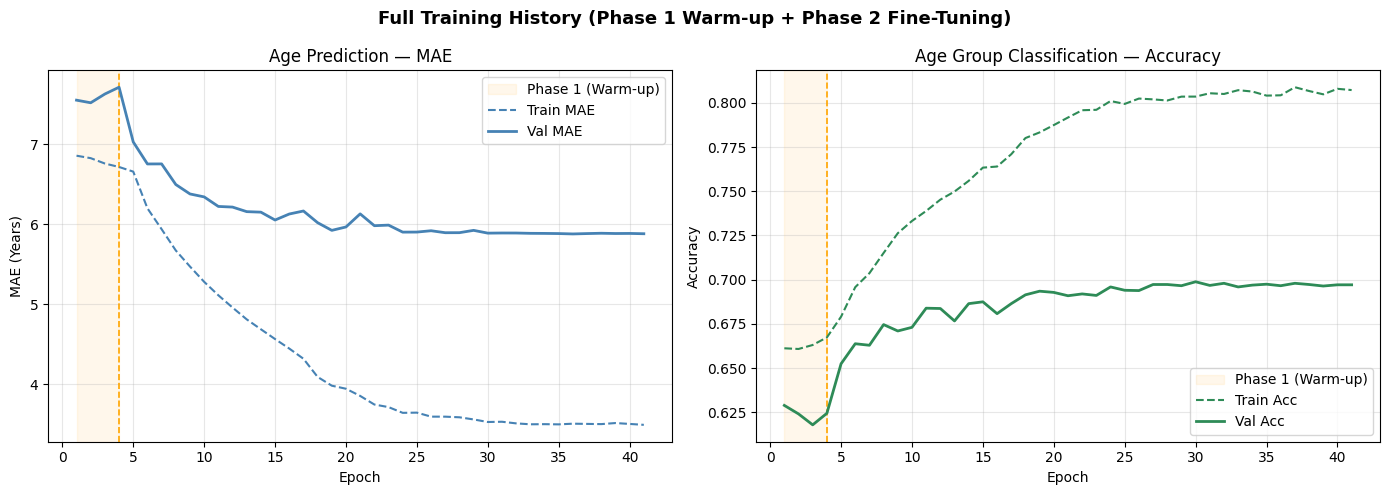

🔄 Generating predictions on test set...


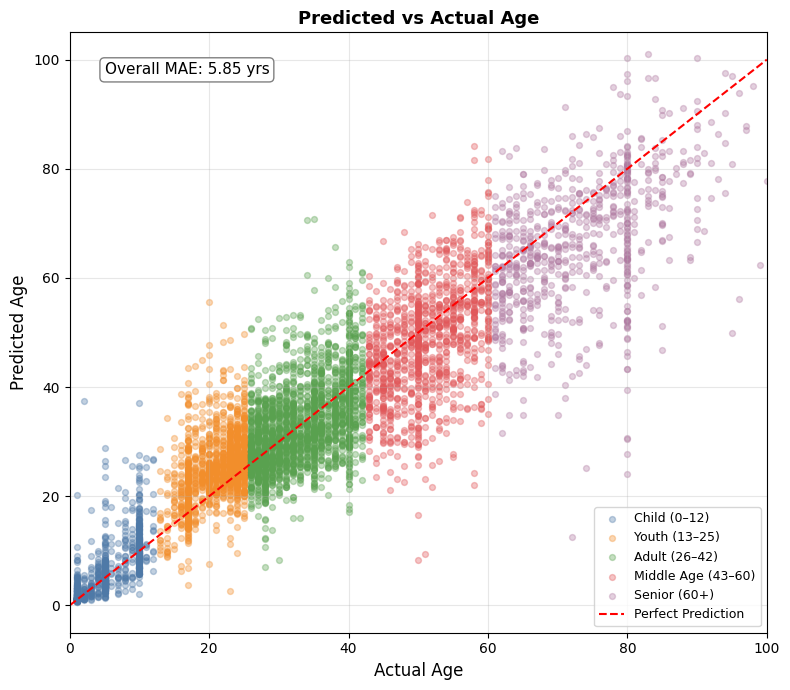

C:\Users\linmy\AppData\Local\Temp\ipykernel_10808\1240423863.py:103: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(group_residuals,


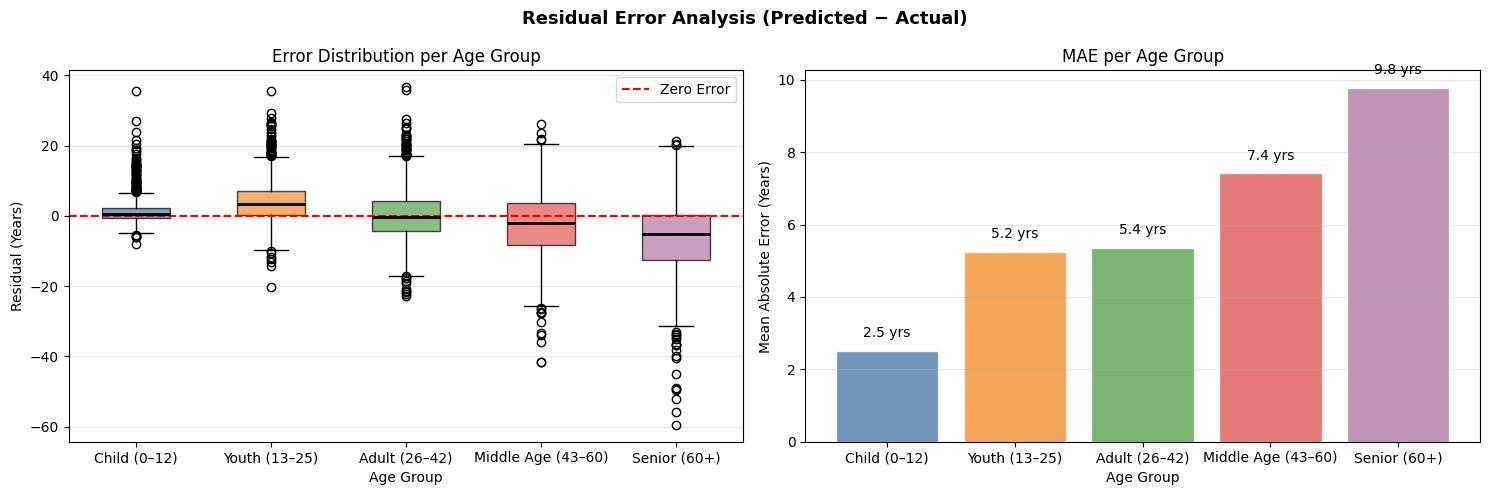

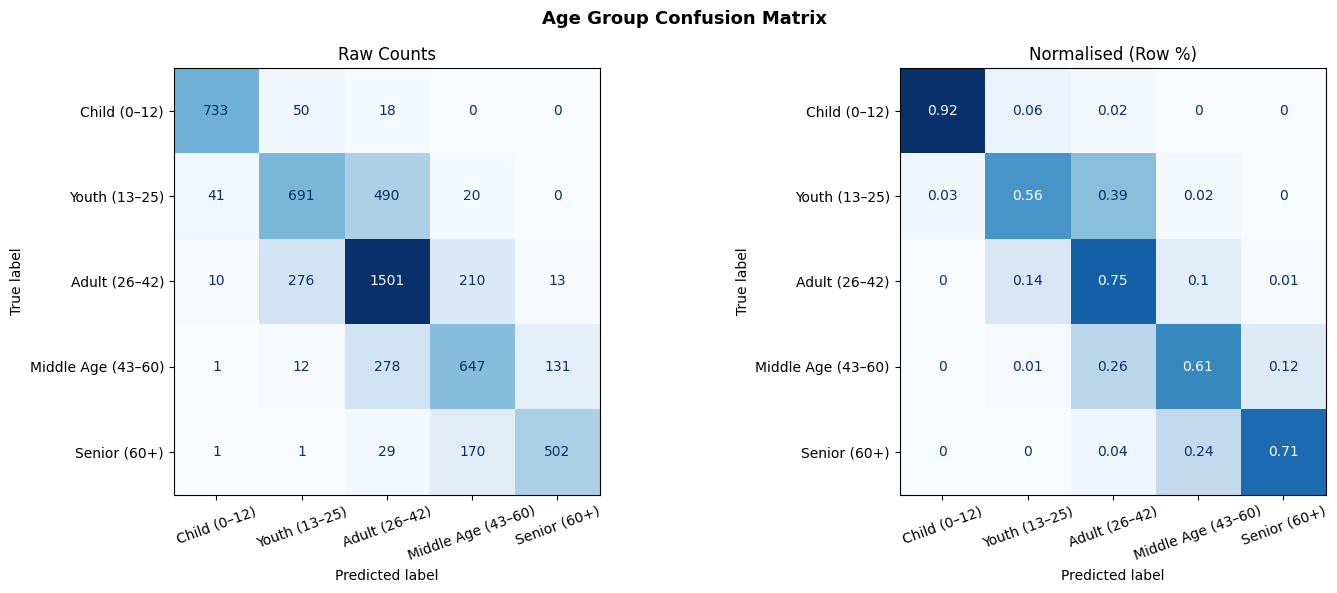


📊 FINAL EVALUATION SUMMARY
  Phase 1 best val MAE:  7.51 years
  Phase 2 best val MAE:  5.88 years
  Overall test MAE:      5.85 years
  Age Group Accuracy:    69.94%

  MAE by Age Group:
    Child (0–12)            2.50 yrs  ██
    Youth (13–25)           5.25 yrs  █████
    Adult (26–42)           5.36 yrs  █████
    Middle Age (43–60)      7.41 yrs  ███████
    Senior (60+)            9.77 yrs  █████████


In [84]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ── 0. Combine both training histories for full picture ───────────────────────
# I stitch Phase 1 and Phase 2 histories together so the curve shows
# the complete training journey from start to finish
def combine_histories(h1, h2, metric):
    return h1.history.get(metric, []) + h2.history.get(metric, [])

epochs_warmup = len(history_warmup.history["age_output_mae"])
epochs_total  = epochs_warmup + len(history_fine.history["age_output_mae"])

train_mae = combine_histories(history_warmup, history_fine, "age_output_mae")
val_mae   = combine_histories(history_warmup, history_fine, "val_age_output_mae")
train_acc = combine_histories(history_warmup, history_fine, "age_group_output_accuracy")
val_acc   = combine_histories(history_warmup, history_fine, "val_age_group_output_accuracy")

# ── 1. Training Curves ────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Full Training History (Phase 1 Warm-up + Phase 2 Fine-Tuning)",
             fontsize=13, fontweight="bold")

epoch_range = range(1, epochs_total + 1)

# Shade Phase 1 region so it's easy to see where fine-tuning began
for ax in axes:
    ax.axvspan(1, epochs_warmup, alpha=0.08, color="orange", label="Phase 1 (Warm-up)")
    ax.axvline(epochs_warmup, color="orange", linestyle="--", linewidth=1.2)

# MAE
axes[0].plot(epoch_range, train_mae, label="Train MAE", color="steelblue",
             linestyle="--", linewidth=1.5)
axes[0].plot(epoch_range, val_mae,   label="Val MAE",   color="steelblue", linewidth=2)
axes[0].set_title("Age Prediction — MAE")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MAE (Years)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Age Group Accuracy
axes[1].plot(epoch_range, train_acc, label="Train Acc", color="seagreen",
             linestyle="--", linewidth=1.5)
axes[1].plot(epoch_range, val_acc,   label="Val Acc",   color="seagreen", linewidth=2)
axes[1].set_title("Age Group Classification — Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ── 2. Collect Predictions on Test Set ───────────────────────────────────────
print("🔄 Generating predictions on test set...")
predictions = best_model.predict(test_ds, verbose=0)

y_group_pred_probs = predictions[0]
y_age_pred         = predictions[1].flatten()
y_group_pred       = np.argmax(y_group_pred_probs, axis=1)

y_age_true   = np.concatenate([y["age_output"]       for _, y in test_ds], axis=0)
y_group_true = np.concatenate([y["age_group_output"] for _, y in test_ds], axis=0)

AGE_GROUP_NAMES = ["Child\n(0–12)", "Youth\n(13–25)", "Adult\n(26–42)",
                   "Middle Age\n(43–60)", "Senior\n(60+)"]
colours = ["#4e79a7", "#f28e2b", "#59a14f", "#e15759", "#b07aa1"]

# ── 3. Predicted vs Actual Scatter ───────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 7))

for group_id in range(5):
    mask = y_group_true == group_id
    ax.scatter(y_age_true[mask], y_age_pred[mask],
               alpha=0.35, s=18, color=colours[group_id],
               label=AGE_GROUP_NAMES[group_id].replace("\n", " "))

ax.plot([0, 100], [0, 100], "r--", linewidth=1.5, label="Perfect Prediction")

mae = np.mean(np.abs(y_age_pred - y_age_true))
ax.text(0.05, 0.93, f"Overall MAE: {mae:.2f} yrs", transform=ax.transAxes,
        fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="grey"))

ax.set_xlim([0, 100]); ax.set_ylim([-5, 105])
ax.set_xlabel("Actual Age", fontsize=12)
ax.set_ylabel("Predicted Age", fontsize=12)
ax.set_title("Predicted vs Actual Age", fontsize=13, fontweight="bold")
ax.legend(loc="lower right", fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ── 4. Residual Error by Age Group ───────────────────────────────────────────
residuals = y_age_pred - y_age_true

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Residual Error Analysis (Predicted − Actual)", fontsize=13, fontweight="bold")

group_residuals = [residuals[y_group_true == g] for g in range(5)]

# Boxplot
bp = axes[0].boxplot(group_residuals,
                     labels=[n.replace("\n", " ") for n in AGE_GROUP_NAMES],
                     patch_artist=True,
                     medianprops=dict(color="black", linewidth=2))
for patch, colour in zip(bp["boxes"], colours):
    patch.set_facecolor(colour); patch.set_alpha(0.7)
axes[0].axhline(0, color="red", linestyle="--", linewidth=1.5, label="Zero Error")
axes[0].set_xlabel("Age Group"); axes[0].set_ylabel("Residual (Years)")
axes[0].set_title("Error Distribution per Age Group")
axes[0].legend(); axes[0].grid(True, alpha=0.3, axis="y")

# MAE bar chart
mae_per_group = [np.mean(np.abs(r)) for r in group_residuals]
bars = axes[1].bar([n.replace("\n", " ") for n in AGE_GROUP_NAMES],
                   mae_per_group, color=colours, alpha=0.8, edgecolor="white")
for bar, val in zip(bars, mae_per_group):
    axes[1].text(bar.get_x() + bar.get_width() / 2,
                 bar.get_height() + 0.3, f"{val:.1f} yrs",
                 ha="center", va="bottom", fontsize=10)
axes[1].set_xlabel("Age Group"); axes[1].set_ylabel("Mean Absolute Error (Years)")
axes[1].set_title("MAE per Age Group")
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# ── 5. Confusion Matrix ───────────────────────────────────────────────────────
cm      = confusion_matrix(y_group_true, y_group_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Age Group Confusion Matrix", fontsize=13, fontweight="bold")

labels = [n.replace("\n", " ") for n in AGE_GROUP_NAMES]

ConfusionMatrixDisplay(cm,      display_labels=labels).plot(ax=axes[0], colorbar=False, cmap="Blues")
axes[0].set_title("Raw Counts"); axes[0].tick_params(axis="x", rotation=20)

ConfusionMatrixDisplay(np.round(cm_norm, 2), display_labels=labels).plot(
    ax=axes[1], colorbar=False, cmap="Blues")
axes[1].set_title("Normalised (Row %)"); axes[1].tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

# ── 6. Final Summary ─────────────────────────────────────────────────────────
print("\n📊 FINAL EVALUATION SUMMARY")
print("=" * 45)
print(f"  Phase 1 best val MAE:  {min(val_mae[:epochs_warmup]):.2f} years")
print(f"  Phase 2 best val MAE:  {min(val_mae[epochs_warmup:]):.2f} years")
print(f"  Overall test MAE:      {mae:.2f} years")
print(f"  Age Group Accuracy:    {np.mean(y_group_pred == y_group_true)*100:.2f}%")
print()
print("  MAE by Age Group:")
for name, err in zip(AGE_GROUP_NAMES, mae_per_group):
    label = name.replace('\n', ' ')
    bar   = "█" * int(err)
    print(f"    {label:<22} {err:5.2f} yrs  {bar}")
print("=" * 45)